In [11]:
! pip install qiskit --quiet
! pip install qiskit-aer --quiet
! pip install torchvision --quiet


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [12]:
import numpy as np
import torchvision
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import keras

from qiskit import transpile, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from PIL import Image
from keras.datasets import mnist

In [13]:
def calc_angle(prob):
    #Calculate the angle using the formula
    return 2 * np.arccos(np.sqrt(prob))

def create_quantum_circuit(null_prior, null_probs, positive_probs):
    # Calculate angles based on the provided probabilities
    theta_y = calc_angle(null_prior)
    null_rotations = [calc_angle(conditional) for conditional in null_probs]
    pos_rotations = [calc_angle(conditional) for conditional in positive_probs]

    # Initialize the quantum circuit with n qubits and n classical bits
    assert(len(null_probs) == len(positive_probs))
    n = len(null_probs) #Number of features
    circ = QuantumCircuit(n+1) #Add one for prior

    # Implementing the gates based on the calculated thetas
    circ.ry(theta_y, 0)  # Encode P(y=0) into qubit 0
    for i in range(n):
        circ.cry(null_rotations[i], 0, i+1)
    circ.x(0)  # Flip y to represent y=1
    for i in range(n):
        circ.cry(pos_rotations[i], 0, i+1) # Now for y=1, encode P(x1|y=1)
    circ.x(0)  # Reset y back

    # Measure
    circ.measure_all()  # Measure both the label and feature qubits

    return circ

In [14]:
class BinaryPreprocess:
    def __init__(self, diffclasses: list, mnist_path: str = 'data', dd: bool = True):
        dataset = torchvision.datasets.MNIST(root=mnist_path, train=True, download=dd)

        class_features = BinaryPreprocess._processMNIST(dataset)

        self.classes = diffclasses
        self.features = class_features[diffclasses] #2 x 2 x Features]

        self.null_probs = torch.zeros(9)
        self.positive_probs = torch.zeros(9)

        diffclasses_count = 0
        prior_count = 0
        for (data, label) in dataset:
            if label in diffclasses:
                diffclasses_count += 1
                binarized_features = self.inference_features(data)
                if label == diffclasses[0]:
                    prior_count += 1
                    self.null_probs += binarized_features.squeeze()
                else:
                    self.positive_probs += binarized_features.squeeze()

        positive_count = diffclasses_count - prior_count
        self.prior = prior_count / diffclasses_count
        self.null_probs /= prior_count
        self.positive_probs /= positive_count

    def inference_features(self, img):
        """
        Binarization of img average features between the two classes
        input: img 28 x 28 image
        """
        img = torch.from_numpy(np.array(img)).float()
        img = img[1:,1:]

        avg_kernel = torch.ones((8,8)) / 64
        x_prime = F.conv2d(img[None, :], avg_kernel[None, None, :], stride=9).reshape(1, -1)
        divpoint = (self.features[0, 0] * self.features[1, 1] - self.features[1, 0] * self.features[0, 1]) / (self.features[0, 1] - self.features[1, 1])

        over_div = x_prime > divpoint
        mu_diff = self.features[0, 0] > self.features[1, 0]

        return torch.logical_xor(over_div, mu_diff).float()


    def _processMNIST(dataset):
        avg_kernel = torch.ones((8, 8)) / 64

        stats = torch.zeros((0,9))
        labels = torch.zeros(len(dataset))

        for i, (data, label) in enumerate(dataset):
            img = torch.from_numpy(np.array(data)).float()
            img = img[1:,1:]

            mean_pooled = F.conv2d(img[None, :], avg_kernel[None, None, :], stride=9).reshape(1, -1)

            stats = torch.cat([stats, mean_pooled])

            labels[i] = label

        class_features = torch.zeros((10, 2, 9)) #Classes x Statistics x Features
        for i in range(len(class_features)):
            subset = stats[labels == i]
            feat_mean = subset.mean(dim=0) #Shape should be 9 for both
            feat_std = subset.var(dim=0)

            class_features[i] = torch.stack((feat_mean, feat_std)) #class_features[c][0] -> means, [c][1] -> variance

        return class_features

In [35]:
import Naive_qbc_ as nqbc
from processed_dataset import BinaryPreprocess
from qiskit import transpile, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

import torch
import torchvision
import numpy as np
from PIL import Image

null_class = 0
alt_class = 1

class classicalBayes:
    def __init__(self, null_prior, null_probs, positive_probs):
        self.null_prior = null_prior
        self.null_probs = null_probs
        self.positive_probs = positive_probs
    
    def inference(self, sample):
        null_prob = self.null_prior
        alt_prob = 1 - self.null_prior

        for i in range(len(self.positive_probs)):
            if sample[i]:
                null_prob *= self.null_probs[i]
                alt_prob *= self.positive_probs[i]
            else:
                null_prob *= (1 - self.null_probs[i])
                alt_prob *= (1 - self.positive_probs[i])
        
        return 1 if alt_prob > null_prob else 0
    
def create_quantum_circuit_mult(priors, null_probs_list, positive_probs_list):
    # Number of classes and required qubits for class representation
    num_classes = len(priors)
    num_class_qubits = int(np.ceil(np.log2(num_classes)))
    # Number of features
    n = len(null_probs_list[0])
    
    # Initialize the quantum circuit with n + num_class_qubits qubits
    circ = QuantumCircuit(n + num_class_qubits)
    
    # Encode class-prior probabilities
    for i in range(num_classes):
        binary_representation = format(i, f'0{num_class_qubits}b')
        theta_y = calc_angle(priors[i])
        for j, bit in enumerate(binary_representation):
            if bit == '1':
                circ.x(j)
        circ.ry(theta_y, num_class_qubits - 1)  # Encode P(y=i) into the last class qubit
        for j, bit in enumerate(binary_representation):
            if bit == '1':
                circ.x(j)

    # Encode class-conditional probabilities
    for i in range(num_classes):
        binary_representation = format(i, f'0{num_class_qubits}b')
        null_rotations = [calc_angle(conditional) for conditional in null_probs_list[i]]
        pos_rotations = [calc_angle(conditional) for conditional in positive_probs_list[i]]

        for j, bit in enumerate(binary_representation):
            if bit == '1':
                circ.x(j)
        for k in range(n):
            circ.cry(null_rotations[k], num_class_qubits - 1, num_class_qubits + k)
        circ.x(num_class_qubits - 1)  # Flip y to represent y=i
        for k in range(n):
            circ.cry(pos_rotations[k], num_class_qubits - 1, num_class_qubits + k)
        circ.x(num_class_qubits - 1)  # Reset y back
        for j, bit in enumerate(binary_representation):
            if bit == '1':
                circ.x(j)
    
    # Measure all qubits
    circ.measure_all()
    
    return circ
if __name__ == "__main__":
    preproc = BinaryPreprocess([0, 1, 2, 3])

    #print first ten preproc.prior
    print(f"Preproc prior is: {preproc.prior[:10]}")
    # Null prior, null probs, positive probs
    naive_qbc = create_quantum_circuit_mult(preproc.prior, preproc.null_probs.tolist(), preproc.positive_probs.tolist())    
    classical_bayes = classicalBayes(preproc.prior, preproc.null_probs.tolist(), preproc.positive_probs.tolist())
    
    # Print mpl of naive_qbc
    print(naive_qbc)
    

    val_set = torchvision.datasets.MNIST(root='data', train=False)

    total = 0
    classical_correct = 0
    quantum_correct = 0

    print(f"Length of val_set: {len(val_set)}")
    for (img, label) in val_set:
        if label in [0, 1, 2, 3]:
            img = torch.from_numpy(np.array(img.convert('L')))
            binarized_features = preproc.inference_features(img).squeeze()

            pre_circ = QuantumCircuit(len(preproc.null_probs) + 1)

            for i in range(len(binarized_features)):
                if binarized_features[i].item() == 1:
                    pre_circ.x(i + 1)
            
            if total == 0:
                print("Preprocessed Circuit")
                pre_circ.draw('mpl')
                plt.show()

            # Compose the pre_circ with the naive_QBC
            composite = pre_circ.compose(naive_qbc)
            
            if total == 0:
                print("Composite Circuit")
                print(composite)
                

            simulator = AerSimulator()
            shots = 1024
            
            composite = transpile(composite, simulator)
            result = simulator.run(composite, shots=shots).result()
            counts = result.get_counts(composite)

            matched_counts = {}
            for output in counts.keys():
                for i in range(len(binarized_features)):
                    n = len(binarized_features) - 1  # Output is little-endian
                    if float(output[i]) != binarized_features[n - i].item():
                        continue
                    matched_counts[output[-1]] = counts[output]

            quantum_pred = 1 if matched_counts.get('1', 0) > matched_counts.get('0', 0) else 0
            if quantum_pred == label:
                quantum_correct += 1
            if classical_bayes.inference(binarized_features) == label:
                classical_correct += 1
            total += 1

    print(f"Classical Accuracy: {classical_correct / total}")
    print(f"Quantum Accuracy: {quantum_correct / total}")


TypeError: 'float' object is not subscriptable

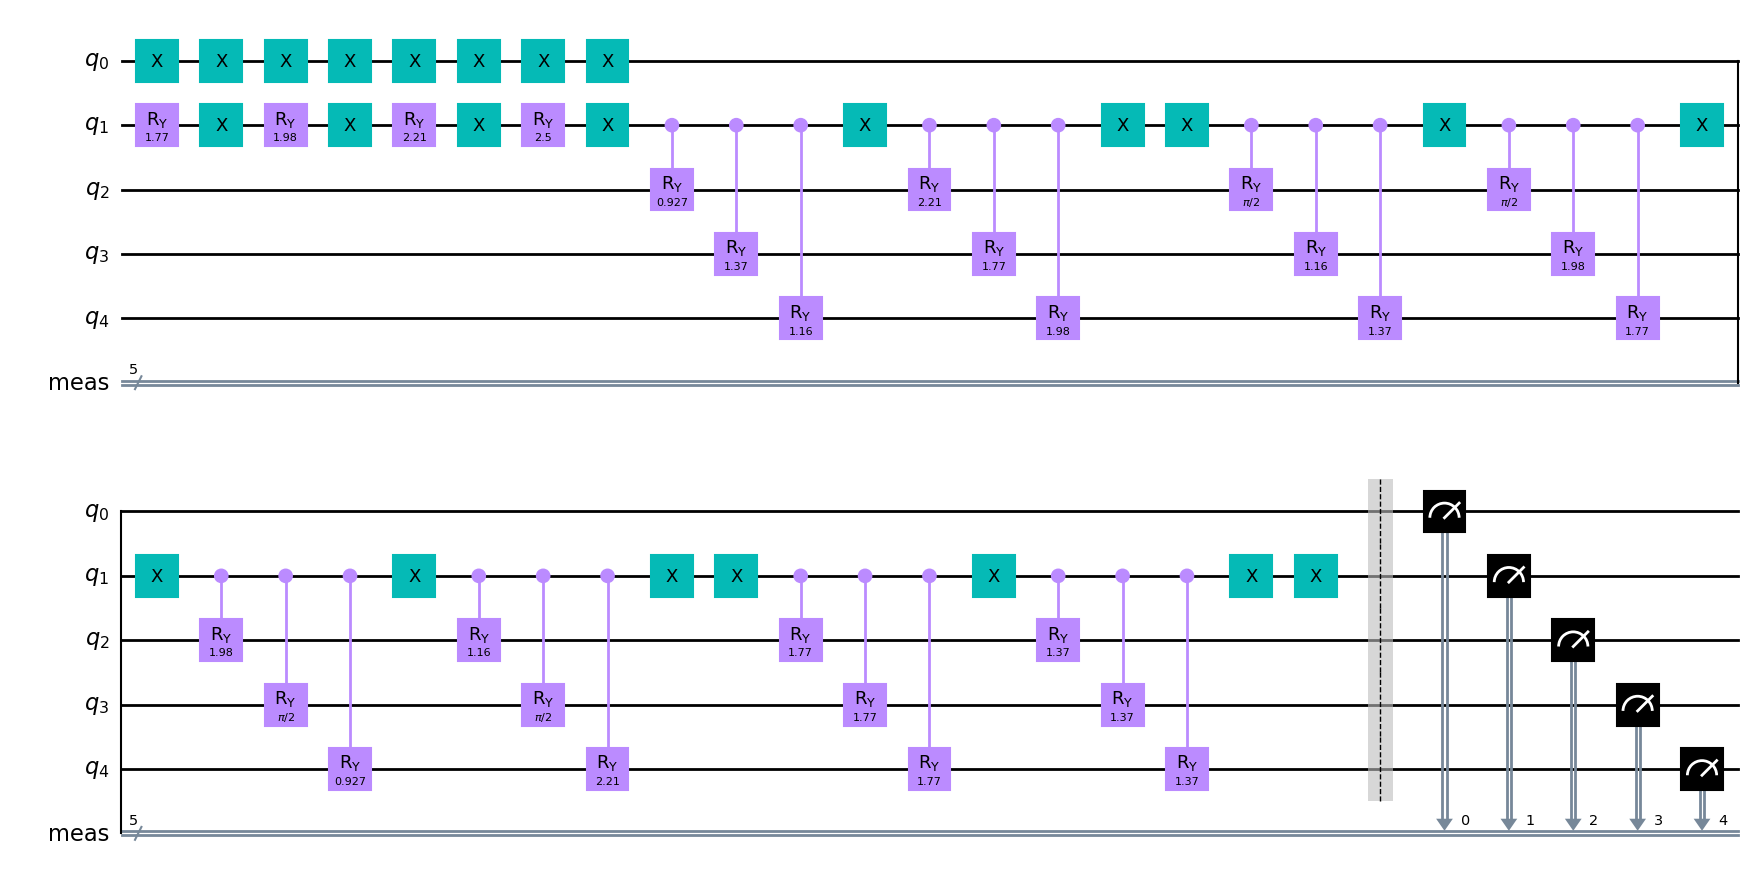

In [14]:
from qiskit import QuantumCircuit
import numpy as np

# Function to calculate rotation angle
def calc_angle(prob):
    return 2 * np.arccos(np.sqrt(prob))

def create_quantum_circuit_mult(priors, null_probs_list, positive_probs_list):
    # Number of classes and required qubits for class representation
    num_classes = len(priors)
    num_class_qubits = int(np.ceil(np.log2(num_classes)))
    # Number of features
    n = len(null_probs_list[0])
    
    # Initialize the quantum circuit with n + num_class_qubits qubits
    circ = QuantumCircuit(n + num_class_qubits)
    
    # Encode class-prior probabilities
    for i in range(num_classes):
        binary_representation = format(i, f'0{num_class_qubits}b')
        theta_y = calc_angle(priors[i])
        for j, bit in enumerate(binary_representation):
            if bit == '1':
                circ.x(j)
        circ.ry(theta_y, num_class_qubits - 1)  # Encode P(y=i) into the last class qubit
        for j, bit in enumerate(binary_representation):
            if bit == '1':
                circ.x(j)

    # Encode class-conditional probabilities
    for i in range(num_classes):
        binary_representation = format(i, f'0{num_class_qubits}b')
        null_rotations = [calc_angle(conditional) for conditional in null_probs_list[i]]
        pos_rotations = [calc_angle(conditional) for conditional in positive_probs_list[i]]

        for j, bit in enumerate(binary_representation):
            if bit == '1':
                circ.x(j)
        for k in range(n):
            circ.cry(null_rotations[k], num_class_qubits - 1, num_class_qubits + k)
        circ.x(num_class_qubits - 1)  # Flip y to represent y=i
        for k in range(n):
            circ.cry(pos_rotations[k], num_class_qubits - 1, num_class_qubits + k)
        circ.x(num_class_qubits - 1)  # Reset y back
        for j, bit in enumerate(binary_representation):
            if bit == '1':
                circ.x(j)
    
    # Measure all qubits
    circ.measure_all()
    
    return circ

# Example usage
priors = [0.4, 0.3, 0.2, 0.1]  # Example class-prior probabilities for 4 classes
null_probs_list = [
    [0.8, 0.6, 0.7],  # Example class-conditional probabilities for class 0
    [0.5, 0.7, 0.6],  # Example class-conditional probabilities for class 1
    [0.3, 0.5, 0.8],  # Example class-conditional probabilities for class 2
    [0.4, 0.4, 0.4]   # Example class-conditional probabilities for class 3
]
positive_probs_list = [
    [0.2, 0.4, 0.3],  # Example class-conditional probabilities for class 0
    [0.5, 0.3, 0.4],  # Example class-conditional probabilities for class 1
    [0.7, 0.5, 0.2],  # Example class-conditional probabilities for class 2
    [0.6, 0.6, 0.6]   # Example class-conditional probabilities for class 3
]

quantum_circuit = create_quantum_circuit_mult(priors, null_probs_list, positive_probs_list)
quantum_circuit.draw('mpl')


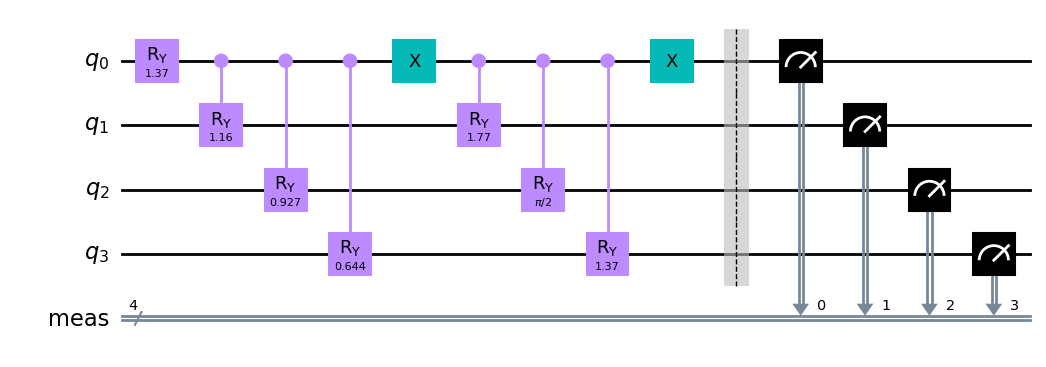

In [17]:
def calc_angle(prob):
    # Calculate the angle using the formula
    return 2 * np.arccos(np.sqrt(prob))

def create_quantum_circuit(null_prior, null_probs, positive_probs):
    # Calculate angles based on the provided probabilities
    theta_y = calc_angle(null_prior)
    null_rotations = [calc_angle(conditional) for conditional in null_probs]
    pos_rotations = [calc_angle(conditional) for conditional in positive_probs]
    
    # Initialize the quantum circuit with n qubits and n classical bits
    assert(len(null_probs) == len(positive_probs))
    n = len(null_probs) # Number of features
    circ = QuantumCircuit(n + 1) # Add one for prior
    
    # Implementing the gates based on the calculated thetas
    circ.ry(theta_y, 0)  # Encode P(y=0) into qubit 0
    for i in range(n):
        circ.cry(null_rotations[i], 0, i + 1)
    circ.x(0)  # Flip y to represent y=1
    for i in range(n):
        circ.cry(pos_rotations[i], 0, i + 1) # Now for y=1, encode P(x1|y=1)
    circ.x(0)  # Reset y back
    
    # Measure 
    circ.measure_all()  # Measure both the label and feature qubits
    
    return circ

# Example usage
null_prior = 0.6  # Example prior probability for y=0
null_probs = [0.7, 0.8, 0.9]  # Example class-conditional probabilities for y=0
positive_probs = [0.4, 0.5, 0.6]  # Example class-conditional probabilities for y=1

quantum_circuit = create_quantum_circuit(null_prior, null_probs, positive_probs)

# Draw the quantum circuit
quantum_circuit.draw('mpl')
